# <center>LSTM Autoencoding Anomaly Detector</center>
<center>By Nigel Story</center>

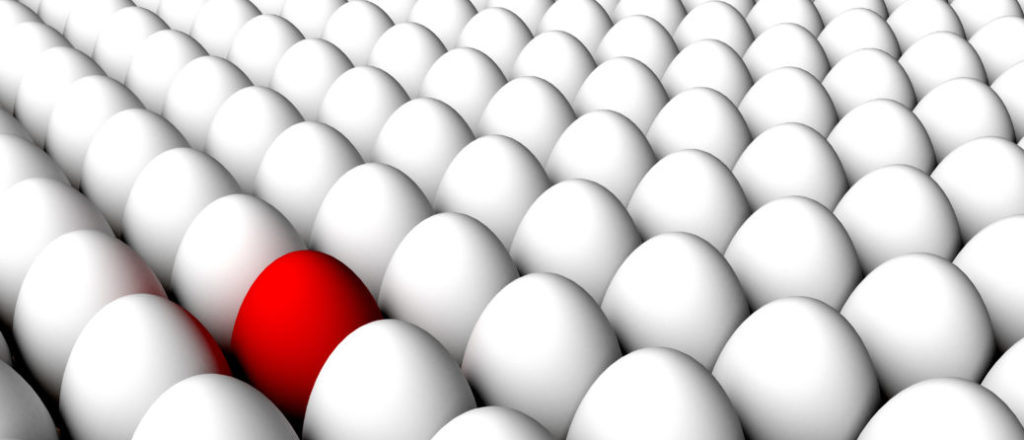

## Contents

* [Introduction](#intro)
    * [About the Data](#about-the-data)
* [ETL](#etl)
* [Anomaly Detection](#anomaly-detection)
    * [How the LSTM Autoencoder Works](#how-lstm)
    * [Creating the Model](#creating)
    * [Training the Model](#training)
    * [Evaluating the Model](#eval)

## Introduction <a class='anchor' id='intro'></a>

We will be exploring the use of Long Short Term Memory (LSTM) Autoencoders in Anomaly Detection. This project was inspired and informed by the *Applied AI and DeepLearning* offered by IBM through Coursera. 

We'll make use of Apache Spark for storing and querying our dataset and Keras for building our deep-learning model. We won't have access to a Spark cluster, so we won't actually be to take advantage of the performance enhancements that Spark offers, but we will be able to demonstrate the syntax and usage.

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import time

import plaidml.keras as pk
pk.install_backend()
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras.callbacks import Callback

%matplotlib inline

### About the Data <a class='anchor' id='about-the-data'></a>

The data we'll be working with are motor vibration data collected by the Case Western Reserve University Bearing Data Center (CWR). The data were generated by motors containing faulty and healthy bearings, measured by two accelerometers: one located near to the bearing and one further away. Faults were seeded into the bearing in a controlled manner to ensure reproducibility. You can read more about the CWR project and view the data <a href="https://csegroups.case.edu/bearingdatacenter/home">here</a>.

## ETL <a class='anchor' id='etl'></a>

The CWR data are stored in Matlab files (.mat) on their server. Our ETL pipeline will fetch the data for healthy and faulty bearings and save them in separate directories. Using the function below, we will read and combine the data from these directories and later save the data as CSVs, to be loaded into Spark DataFrames.

In [3]:
# def read_folder(folder):
#     data = 'dummy'
#     skip = False
#     for file in os.listdir(folder):
#         file_id = file[:-4]
#         mat_file_dict = sio.loadmat(folder + file)
#         del data
#         for key, value in mat_file_dict.items():
#             if 'DE_time' in key or 'FE_time' in key:
#                 a = np.array(mat_file_dict[key])
#                 try:
#                     data
#                 except NameError:
#                     data = a
#                 else:
#                     if (data.shape[0] != a.shape[0]):
#                         print('skipping ' + file_id)
#                         skip = True
#                         continue
#                     data = np.hstack((data, a))    
#         if skip:
#             skip = False
#             continue
#         id = np.repeat(file_id, data.shape[0])
#         id.shape = (id.shape[0], 1)
        
#         data = np.hstack((id, data))
#         if data.shape[1] == 2:
#             zeros = np.repeat(float(0), data.shape[0])
#             zeros.shape = (data.shape[0], 1)
#             data = np.hstack((data, zeros))
#         try:
#             result
#         except NameError:
#             result = data
#         else:
#             result = np.vstack((result, data))
#     return result

#### Get data for healthy bearings

In [4]:
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/97.mat
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/98.mat
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/99.mat
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/100.mat

In [5]:
#!mkdir ./cwr_healthy
#!mv *.mat ./cwr_healthy

#### Get data for faulty bearings

In [6]:
#!for url in `curl -s https://csegroups.case.edu/bearingdatacenter/pages/12k-drive-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
#!for url in `curl -s https://csegroups.case.edu/bearingdatacenter/pages/48k-drive-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
#!for url in `curl -s https://csegroups.case.edu/bearingdatacenter/pages/12k-fan-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done

In [7]:
#!mkdir ./cwr_faulty
#!mv *.mat ./cwr_faulty

#### Save to CSV files

In [8]:
#result_healthy = read_folder('./cwr_healthy')

In [9]:
#pdf = pd.DataFrame(result_healthy)
#pdf.to_csv('result_healthy_pandas.csv', header=False, index=True)

In [10]:
#result_faulty = read_folder('./cwr_faulty')

In [11]:
#pdf = pd.DataFrame(result_faulty)
#pdf.to_csv('result_faulty_pandas.csv', header=False, index=True)

Now that our data are stored in CSVs, we can move on to exploratory analysis and building our model.

## Anomaly Detection <a class='anchor' id='anomaly-detection'></a>

For this project, we'll be using the CWR bearing data to simulate a bearing failure in a motor. The first thing we'll need to do is some simple, high-level EDA to see if we can visualize the difference in behavior between the healthy and faulty data.

Let's start by reading in a sample of 1,000 readings from healthy and faulty bearings. There are two accelerometers generating time series data, so for the sake of visualization, we'll combine the two measurements by taking the Euclidean norm, or magnitude.

In [12]:
df_healthy = spark.read.csv('result_healthy_pandas.csv')
df_healthy.createOrReplaceTempView('df_healthy')

In [13]:
df_faulty = spark.read.csv('result_faulty_pandas.csv')
df_faulty.createOrReplaceTempView('df_faulty')

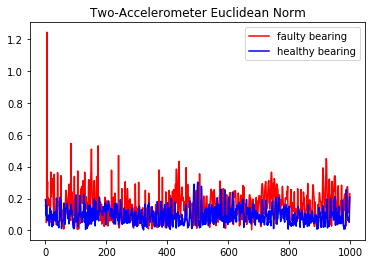

In [29]:
sample_query = 'select sqrt(pow(_c2,2) + pow(_c3,2)) as mag from {} order by _c0 limit 1000'

healthy_sample = np.array(spark.sql(sample_query.format('df_healthy')).rdd.map(lambda row: [row.mag]).collect())
faulty_sample = np.array(spark.sql(sample_query.format('df_faulty')).rdd.map(lambda row: [row.mag]).collect())

plt.title('Two-Accelerometer Euclidean Norm')
plt.plot(faulty_sample, color='red', label='faulty bearing')
plt.plot(healthy_sample, color='blue', label='healthy bearing')
plt.legend()
plt.show()

It's clear that the faulty bearing data is more widely-varying than the healthy data, so let's compare the means and standard deviations of the two.

In [15]:
healthy_mean, healthy_std = (np.mean(healthy_sample), np.std(healthy_sample))
faulty_mean, faulty_std = (np.mean(faulty_sample), np.std(faulty_sample))

print('Healthy bearing: {:.2f} ({:.2f})'.format(healthy_mean, healthy_std))
print('Faulty  bearing: {:.2f} ({:.2f})'.format(faulty_mean, faulty_std))

Healthy bearing: 0.10 (0.05)
Faulty  bearing: 0.15 (0.09)


This alone could be enough to create a pretty effective anomaly detector, by naively assuming the healthy data are normally distributed and finding the z-score of the anomalous readings.

Let do this and define an *Anomaly Score* as the CDF of the standard normal distribution taken at the value of the mean of the faulty data.

In [30]:
z_score = (faulty_mean - healthy_mean) / healthy_std
p_value = stats.norm.sf(z_score)*2 #two-sided p-value

print(f"Faulty Anomaly Score: {round((1-p_value)*100, 2)}%")

Faulty Anomaly Score: 72.28%


Using this method, we don't get a particularly powerful model, since being only 72% confident in an anomaly is not particularly persuading.

We'll see that by using an LSTM Autoencoder, we will be able to be much more confident in our output.

### How the LSTM Autoencoder Works <a class='anchor' id='how-lstm'></a>

The idea behind an autoencoder is that you train an artificial neural network to identify its own input data. It sounds redundant, but the trick is that the network has to build in such a way that it reduces its dimensionality, or number of neurons, with each layer, and then has to re-build the original input data. By doing this, the network will generate an encoding of the data in its layer with the fewest neurons that can reliably predict the original data. Because the model won't have any prediction targets and is only used to generate the encoding, it an example of an unsupervised learning method.

We'll use an LSTM as our neural network because we are working with time series data, reading in truncated "recordings" from the bearing dataset and encoding them.

#### How will it work as an anomaly detector?

As we train our autoencoder on the healthy bearing data, our model's loss will converge very quickly. When data from a faulty bearing is then introduced, the model will not be able to predict its values, and the loss will skyrocket. This will produce a much stronger indicator of an anomaly than comparing the distributions as we did above.

### Creating the Model <a class='anchor' id='creating'></a>

We'll start by defining a class to collect the loss history of our model as an extension of the `Callback` class in Keras.

In [17]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

Next, we need to define some parameters for our model and build it out.

Our data is going to be 2-dimensional, and we'll take the truncated recordings as snippets of 100, so the dimensionality of our input data will be (100, 2). We'll set the LSTM layer of our model to have 50 hidden/recurrent layers.

In [18]:
lossHistory = LossHistory()
timesteps = 100
dims = 2

model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, dims), return_sequences=True))
model.add(Dense(2))

model.compile(
    loss='mae',
    optimizer='adam'
)

def train(data):
    model.fit(
        data, data, # the data is being passed as both input and output. this is an autoencoder
        epochs=20,
        batch_size=72,
        validation_data=(data, data),
        verbose=0,
        shuffle=False,
        callbacks=[lossHistory]
    )


INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


In [19]:
def create_trimmed_recording(df, file_id):
    recording = np.array(
        df.orderBy(df['_c0'])
        .where(df['_c1']==file_id)
        .select('_c2', '_c3')
        .rdd.map(lambda row: np.array([row._c2, row._c3])).collect()
    )
    
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (int(samples/timesteps), timesteps, dims)
    
    return recording_trimmed.astype(np.float32)

In [20]:
def run_model_get_losses(df, file_list):
    start = time.time()

    for file_id in file_list:
        recording_trimmed = create_trimmed_recording(df, file_id)
        print("started training on {}".format(file_id))
        train(recording_trimmed)
        print("finished training on {}. Elapsed time: {:.2f}s".format(file_id, time.time() - start))

    print("="*20, "\nFinished job. Elapsed time : {:.2f}s".format(time.time() - start))
              
    return lossHistory.losses

In [21]:
def plot_losses(losses):
    fig, ax = plt.subplots(num=None, figsize=(14,6), facecolor='w', edgecolor='k')
    size = len(losses)
    plt.ylim(0, 0.008)
    ax.plot(range(0, size), losses, '-', color='blue', animated=True, linewidth=1)
    plt.show()

### Training the Model <a class='anchor' id='training'></a>

We'll simulate live-streaming data inputs by reading our recordings from the data files in batches of 100, and after training for some time on healthy bearing data we'll introduce a file from the faulty bearing data.

In [22]:
file_ids = spark.sql('select distinct _c1 from df_healthy').rdd.map(lambda row: row._c1).collect()

started training on 98


INFO:plaidml:Analyzing Ops: 4432 of 9445 operations complete
INFO:plaidml:Analyzing Ops: 3158 of 9445 operations complete
INFO:plaidml:Analyzing Ops: 8823 of 9445 operations complete
INFO:plaidml:Analyzing Ops: 4231 of 4242 operations complete


finished training on 98. Elapsed time: 164.43s
started training on 100


INFO:plaidml:Analyzing Ops: 4087 of 9444 operations complete


finished training on 100. Elapsed time: 318.46s
started training on 97


INFO:plaidml:Analyzing Ops: 3261 of 9445 operations complete
INFO:plaidml:Analyzing Ops: 8863 of 9445 operations complete


finished training on 97. Elapsed time: 400.42s
Finished job. Elapsed time : 400.42s


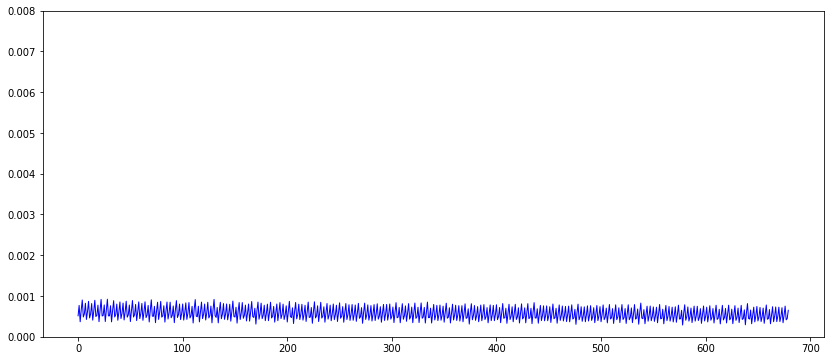

In [23]:
healthy_losses = run_model_get_losses(df_healthy, file_ids)
plot_losses(healthy_losses)

Here we can see that our autoencoder is working well; the loss has converged quickly and has remained low in value and variance. The sawtooth pattern of the loss comes from the learning rate of our model, as the model updates its weights and over-steps the optimum value. This will always occur in a deep learning model since the probability of selecting the optimum value in a continuous space is 0.

#### Adding Anomalous Data

Now that the autoencoder has been trained on the healthy data, let's introduce our anomalous readings -- the faulty bearing data -- and observe the model's loss history.

In [24]:
faulty_losses = run_model_get_losses(df_faulty, [105])

started training on 105


INFO:plaidml:Analyzing Ops: 4999 of 9445 operations complete


finished training on 105. Elapsed time: 60.95s
Finished job. Elapsed time : 60.95s


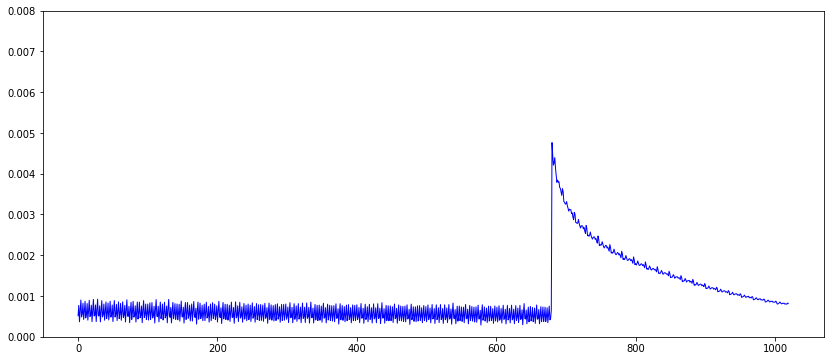

In [25]:
plot_losses(healthy_losses + faulty_losses)

### Evaluating the Model <a class='anchor' id='eval'></a>

We can see a very clear indication of the faulty data in the sudden spike in our model's loss.

Let's evaluate the anomaly using the same method we used to compare the Euclidean norms of the healthy and faulty data.

In [31]:
healthy_loss_mean, healthy_loss_std = np.array(healthy_losses).mean(), np.array(healthy_losses).std()
faulty_loss_mean = np.array(faulty_losses).mean()

z_score_loss = (faulty_loss_mean - healthy_loss_mean) / healthy_loss_std
p_value = stats.norm.sf(z_score_loss)*2 #two-side p-value

print(f"Faulty Loss-Based Anomaly Score: {round((1-p_value)*100, 2)}%")

Faulty Loss-Based Anomaly Score: 100.0%


We see a great improvement in our anomaly detector: from an anomaly score of 72% to 100%. The increase in our model's loss created a much greater amount of separability, allowing for much more confidence in our identification of anomalies.

### Thanks for reading!